In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

In [2]:
heart_csv_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/explainable-ai-heart/models/lifestyle-metrics-model/data/life-heart.csv'
dataframe = pd.read_csv(heart_csv_path)
print(dataframe.describe())
print(dataframe.shape)
dataframe['target'] = np.where(dataframe['heartDisease']=='Yes', 1, 0)
dataframe = dataframe.drop(columns=['heartDisease'])
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
neg, pos = np.bincount(dataframe['target'])

                 bmi  physicalHealth   mentalHealth     sleepHours
count  319795.000000    319795.00000  319795.000000  319795.000000
mean       28.325399         3.37171       3.898366       7.097075
std         6.356100         7.95085       7.955235       1.436007
min        12.020000         0.00000       0.000000       1.000000
25%        24.030000         0.00000       0.000000       6.000000
50%        27.340000         0.00000       0.000000       7.000000
75%        31.420000         2.00000       3.000000       8.000000
max        94.850000        30.00000      30.000000      24.000000
(319795, 17)


In [3]:
def df_to_dataset(df, batch_size=32):
    df = df.copy()
    labels = df.pop('target')
    tf_dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    shuffled_tf_dataset = tf_dataset.shuffle(buffer_size=len(df)) # shuffling values 
    return shuffled_tf_dataset.batch(batch_size) # returning 32 samples per batch

In [4]:
# with large batch size
batch_size=1024
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train_ds = df_to_dataset(df=train, batch_size=batch_size )
val_ds = df_to_dataset(df=val, batch_size=batch_size)
test_ds = df_to_dataset(df=test, batch_size=batch_size)
##steps_per_epoch = np.ceil(2.0*pos/batch_size)
##print(steps_per_epoch)

In [5]:
def get_normalization_layer(feature_name, dataset):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_ds)
    return normalizer
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_ds)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [6]:
# preprocess all features:
inputs = []
encoded_features =[]

# numerical
for header in ["bmi", "physicalHealth", "mentalHealth", 'sleepHours' ]:
    num_col = tf.keras.Input(shape=(1,), name=header)
    # keras inputs array
    inputs.append(num_col)

    norm_layer = get_normalization_layer(feature_name=header, dataset=train_ds)
    encoded_num_col = norm_layer(num_col)
    # encoded feature
    encoded_features.append(encoded_num_col)

# categorical
for header in ["smoking","alcoholDrinking","stroke","diffWalk",
                "sex", "ageGroup", "diabetic", "physicalActivity", 
                "overallHealth", "asthma", "kidneyDisease", "skinCancer"]:
    
    # declare header as a keras Input
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # keras inputs array
    inputs.append(cat_col)

    # get preprocessing layer 
    cat_layer = get_category_encoding_layer(feature_name=header,
                                            dataset=train_ds, 
                                            dtype='string', 
                                            max_tokens=None)
    encoded_cat_col = cat_layer(cat_col)
    # encoded feature
    encoded_features.append(encoded_cat_col)

In [7]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=128, activation="relu")(features)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [9]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=100,
                    # steps_per_epoch=steps_per_epoch,
                    use_multiprocessing=True, 
                    verbose=1)

predictions = model.predict(test_ds)

binary_predictions = tf.round(predictions).numpy().flatten()

Epoch 1/100
250/250 [==============================] - 13s 35ms/step - loss: 0.2272 - accuracy: 0.9157 - val_loss: 0.2227 - val_accuracy: 0.9173
Epoch 2/100
250/250 [==============================] - 13s 47ms/step - loss: 0.2264 - accuracy: 0.9161 - val_loss: 0.2219 - val_accuracy: 0.9171
Epoch 3/100
250/250 [==============================] - 19s 55ms/step - loss: 0.2262 - accuracy: 0.9160 - val_loss: 0.2231 - val_accuracy: 0.9171
Epoch 4/100
250/250 [==============================] - 19s 56ms/step - loss: 0.2259 - accuracy: 0.9161 - val_loss: 0.2218 - val_accuracy: 0.9171
Epoch 5/100
250/250 [==============================] - 17s 52ms/step - loss: 0.2257 - accuracy: 0.9162 - val_loss: 0.2219 - val_accuracy: 0.9173
Epoch 6/100
250/250 [==============================] - 18s 54ms/step - loss: 0.2252 - accuracy: 0.9163 - val_loss: 0.2220 - val_accuracy: 0.9173
Epoch 7/100
250/250 [==============================] - 11s 34ms/step - loss: 0.2249 - accuracy: 0.9162 - val_loss: 0.2218 - val_ac

KeyboardInterrupt: 

In [10]:
def df_to_dataset(df, batch_size=32, resample=False):
    df = df.copy()
    if resample:
        pos_df = df[df['target'] == 1]
        neg_df = df[df['target'] == 0]
        pos_labels = pos_df.pop('target')
        pos_features = pos_df
        neg_labels = neg_df.pop('target')
        neg_features = neg_df
        pos_ds = tf.data.Dataset.from_tensor_slices((dict(pos_features), pos_labels))
        neg_ds = tf.data.Dataset.from_tensor_slices((dict(neg_features), neg_labels))
        
        resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
        #resampled_ds = resampled_ds.apply(tf.data.experimental.assert_cardinality(54748))
        resampled_ds = resampled_ds.shuffle(buffer_size=len(df))
        resampled_ds = resampled_ds.batch(batch_size).prefetch(2)
        return resampled_ds.repeat(3)
    else:
        labels = df.pop('target')
        tf_dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels))
        shuffled_tf_dataset = tf_dataset.shuffle(buffer_size=len(df)) # shuffling values 
        return shuffled_tf_dataset.batch(batch_size).prefetch(2).repeat(2) # returning 32 samples per batch

In [11]:
# with large batch size
batch_size=1024
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train_ds = df_to_dataset(df=train, batch_size=batch_size )
val_ds = df_to_dataset(df=val, batch_size=batch_size)
test_ds = df_to_dataset(df=test, batch_size=batch_size)
##steps_per_epoch = np.ceil(2.0*pos/batch_size)
##print(steps_per_epoch)

In [12]:
def get_normalization_layer(feature_name, dataset):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_ds)
    return normalizer
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_ds)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [14]:
heart_csv_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/explainable-ai-heart/models/lifestyle-metrics-model/data/life-heart.csv'
dataframe = pd.read_csv(heart_csv_path)
print(dataframe.describe())
print(dataframe.shape)
dataframe['target'] = np.where(dataframe['heartDisease']=='Yes', 1, 0)
dataframe = dataframe.drop(columns=['heartDisease'])
dataframe = dataframe.sample(frac=1)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
neg, pos = np.bincount(dataframe['target'])

                 bmi  physicalHealth   mentalHealth     sleepHours
count  319795.000000    319795.00000  319795.000000  319795.000000
mean       28.325399         3.37171       3.898366       7.097075
std         6.356100         7.95085       7.955235       1.436007
min        12.020000         0.00000       0.000000       1.000000
25%        24.030000         0.00000       0.000000       6.000000
50%        27.340000         0.00000       0.000000       7.000000
75%        31.420000         2.00000       3.000000       8.000000
max        94.850000        30.00000      30.000000      24.000000
(319795, 17)


In [15]:
def df_to_dataset(df, batch_size=32, resample=False):
    df = df.copy()
    if resample:
        pos_df = df[df['target'] == 1]
        neg_df = df[df['target'] == 0]
        pos_labels = pos_df.pop('target')
        pos_features = pos_df
        neg_labels = neg_df.pop('target')
        neg_features = neg_df
        pos_ds = tf.data.Dataset.from_tensor_slices((dict(pos_features), pos_labels))
        neg_ds = tf.data.Dataset.from_tensor_slices((dict(neg_features), neg_labels))
        
        resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
        #resampled_ds = resampled_ds.apply(tf.data.experimental.assert_cardinality(54748))
        resampled_ds = resampled_ds.shuffle(buffer_size=len(df))
        resampled_ds = resampled_ds.batch(batch_size).prefetch(2)
        return resampled_ds.repeat(3)
    else:
        labels = df.pop('target')
        tf_dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels))
        shuffled_tf_dataset = tf_dataset.shuffle(buffer_size=len(df)) # shuffling values 
        return shuffled_tf_dataset.batch(batch_size).prefetch(2).repeat(2) # returning 32 samples per batch

In [17]:
def df_to_dataset(df, batch_size=32, resample=False):
    df = df.copy()
    if resample:
        pos_df = df[df['target'] == 1]
        neg_df = df[df['target'] == 0]
        pos_labels = pos_df.pop('target')
        pos_features = pos_df
        neg_labels = neg_df.pop('target')
        neg_features = neg_df
        pos_ds = tf.data.Dataset.from_tensor_slices((dict(pos_features), pos_labels))
        neg_ds = tf.data.Dataset.from_tensor_slices((dict(neg_features), neg_labels))
        
        resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
        #resampled_ds = resampled_ds.apply(tf.data.experimental.assert_cardinality(54748))
        resampled_ds = resampled_ds.shuffle(buffer_size=len(df))
        resampled_ds = resampled_ds.batch(batch_size).prefetch(2)
        return resampled_ds.repeat(3)
    else:
        labels = df.pop('target')
        tf_dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels))
        shuffled_tf_dataset = tf_dataset.shuffle(buffer_size=len(df)) # shuffling values 
        return shuffled_tf_dataset.batch(batch_size).prefetch(2)# returning 32 samples per batch

In [19]:
# with large batch size
batch_size=1024
# train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train, val = train_test_split(dataframe, test_size=0.2, random_state=RANDOM_SEED)
train_ds = df_to_dataset(df=train, batch_size=batch_size )
val_ds = df_to_dataset(df=val, batch_size=batch_size)
# test_ds = df_to_dataset(df=test, batch_size=batch_size)
##steps_per_epoch = np.ceil(2.0*pos/batch_size)
##print(steps_per_epoch)

In [20]:
def get_normalization_layer(feature_name, dataset):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_ds)
    return normalizer
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_ds)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [21]:
# preprocess all features:
inputs = []
encoded_features =[]

# numerical
for header in ["bmi", "physicalHealth", "mentalHealth", 'sleepHours' ]:
    num_col = tf.keras.Input(shape=(1,), name=header)
    # keras inputs array
    inputs.append(num_col)

    norm_layer = get_normalization_layer(feature_name=header, dataset=train_ds)
    encoded_num_col = norm_layer(num_col)
    # encoded feature
    encoded_features.append(encoded_num_col)

# categorical
for header in ["smoking","alcoholDrinking","stroke","diffWalk",
                "sex", "ageGroup", "diabetic", "physicalActivity", 
                "overallHealth", "asthma", "kidneyDisease", "skinCancer"]:
    
    # declare header as a keras Input
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # keras inputs array
    inputs.append(cat_col)

    # get preprocessing layer 
    cat_layer = get_category_encoding_layer(feature_name=header,
                                            dataset=train_ds, 
                                            dtype='string', 
                                            max_tokens=None)
    encoded_cat_col = cat_layer(cat_col)
    # encoded feature
    encoded_features.append(encoded_cat_col)

In [22]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=128, activation="relu")(features)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [23]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=20,
                    # steps_per_epoch=steps_per_epoch,
                    use_multiprocessing=True, 
                    verbose=2)

predictions = model.predict(val_ds)

binary_predictions = tf.round(predictions).numpy().flatten()

Epoch 1/20
250/250 - 21s - loss: 0.2533 - accuracy: 0.9075 - val_loss: 0.2255 - val_accuracy: 0.9165 - 21s/epoch - 83ms/step
Epoch 2/20
250/250 - 19s - loss: 0.2282 - accuracy: 0.9158 - val_loss: 0.2248 - val_accuracy: 0.9162 - 19s/epoch - 76ms/step
Epoch 3/20
250/250 - 20s - loss: 0.2270 - accuracy: 0.9161 - val_loss: 0.2249 - val_accuracy: 0.9161 - 20s/epoch - 80ms/step
Epoch 4/20
250/250 - 33s - loss: 0.2269 - accuracy: 0.9159 - val_loss: 0.2250 - val_accuracy: 0.9162 - 33s/epoch - 134ms/step
Epoch 5/20
250/250 - 33s - loss: 0.2263 - accuracy: 0.9160 - val_loss: 0.2247 - val_accuracy: 0.9163 - 33s/epoch - 133ms/step
Epoch 6/20
250/250 - 28s - loss: 0.2258 - accuracy: 0.9162 - val_loss: 0.2248 - val_accuracy: 0.9160 - 28s/epoch - 112ms/step
Epoch 7/20
250/250 - 31s - loss: 0.2256 - accuracy: 0.9163 - val_loss: 0.2250 - val_accuracy: 0.9164 - 31s/epoch - 124ms/step
Epoch 8/20
250/250 - 31s - loss: 0.2255 - accuracy: 0.9162 - val_loss: 0.2245 - val_accuracy: 0.9160 - 31s/epoch - 123ms/

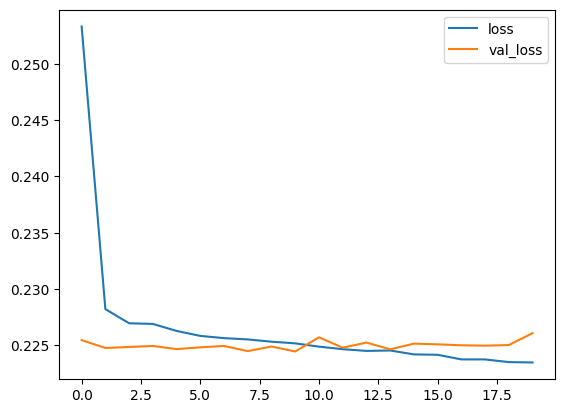

In [24]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [25]:
print(classification_report(val.get('target'), binary_predictions))
# layer connectivity visualization
#tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     58511
           1       0.09      0.01      0.02      5448

    accuracy                           0.90     63959
   macro avg       0.50      0.50      0.49     63959
weighted avg       0.84      0.90      0.87     63959



In [26]:
# with large batch size
batch_size=1024
# train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train, val = train_test_split(dataframe, test_size=0.2, random_state=RANDOM_SEED)
train_ds = df_to_dataset(df=train, batch_size=batch_size, resample=True)
val_ds = df_to_dataset(df=val, batch_size=batch_size, resample=True)
# test_ds = df_to_dataset(df=test, batch_size=batch_size)
##steps_per_epoch = np.ceil(2.0*pos/batch_size)
##print(steps_per_epoch)

In [27]:
def get_normalization_layer(feature_name, dataset):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_ds)
    return normalizer
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_ds)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [29]:
def df_to_dataset(df, batch_size=32, resample=False):
    df = df.copy()
    if resample:
        pos_df = df[df['target'] == 1]
        neg_df = df[df['target'] == 0]
        pos_labels = pos_df.pop('target')
        pos_features = pos_df
        neg_labels = neg_df.pop('target')
        neg_features = neg_df
        pos_ds = tf.data.Dataset.from_tensor_slices((dict(pos_features), pos_labels))
        neg_ds = tf.data.Dataset.from_tensor_slices((dict(neg_features), neg_labels))
        
        resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
        #resampled_ds = resampled_ds.apply(tf.data.experimental.assert_cardinality(54748))
        #resampled_ds = resampled_ds.shuffle(buffer_size=len(df))
        resampled_ds = resampled_ds.batch(batch_size).prefetch(2)
        return resampled_ds
    else:
        labels = df.pop('target')
        tf_dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels)).cache()
        # shuffled_tf_dataset = tf_dataset.shuffle(buffer_size=len(df)) # shuffling values 
        return tf_dataset.batch(batch_size).prefetch(2)# returning 32 samples per batch

In [30]:
# with large batch size
batch_size=1024
# train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train, val = train_test_split(dataframe, test_size=0.2, random_state=RANDOM_SEED)
resampled_train_ds = df_to_dataset(df=train, batch_size=batch_size, resample=True)
val_ds = df_to_dataset(df=val, batch_size=batch_size, resample=False)
# test_ds = df_to_dataset(df=test, batch_size=batch_size)
##steps_per_epoch = np.ceil(2.0*pos/batch_size)
##print(steps_per_epoch)

In [31]:
# with large batch size
batch_size=256
# train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train, val = train_test_split(dataframe, test_size=0.2, random_state=RANDOM_SEED)
resampled_train_ds = df_to_dataset(df=train, batch_size=batch_size, resample=True)
val_ds = df_to_dataset(df=val, batch_size=batch_size, resample=False)
# test_ds = df_to_dataset(df=test, batch_size=batch_size)
##steps_per_epoch = np.ceil(2.0*pos/batch_size)
##print(steps_per_epoch)

In [32]:
def get_normalization_layer(feature_name, dataset):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_ds)
    return normalizer
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_ds)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [33]:
# preprocess all features:
inputs = []
encoded_features =[]

# numerical
for header in ["bmi", "physicalHealth", "mentalHealth", 'sleepHours' ]:
    num_col = tf.keras.Input(shape=(1,), name=header)
    # keras inputs array
    inputs.append(num_col)

    norm_layer = get_normalization_layer(feature_name=header, dataset=resampled_train_ds)
    encoded_num_col = norm_layer(num_col)
    # encoded feature
    encoded_features.append(encoded_num_col)

# categorical
for header in ["smoking","alcoholDrinking","stroke","diffWalk",
                "sex", "ageGroup", "diabetic", "physicalActivity", 
                "overallHealth", "asthma", "kidneyDisease", "skinCancer"]:
    
    # declare header as a keras Input
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # keras inputs array
    inputs.append(cat_col)

    # get preprocessing layer 
    cat_layer = get_category_encoding_layer(feature_name=header,
                                            dataset=resampled_train_ds, 
                                            dtype='string', 
                                            max_tokens=None)
    encoded_cat_col = cat_layer(cat_col)
    # encoded feature
    encoded_features.append(encoded_cat_col)

In [34]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=128, activation="relu")(features)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [35]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(resampled_train_ds, 
                    validation_data=val_ds, 
                    epochs=5,
                    # steps_per_epoch=steps_per_epoch,
                    use_multiprocessing=True, 
                    verbose=2)

predictions = model.predict(val_ds)

binary_predictions = tf.round(predictions).numpy().flatten()

Epoch 1/5
1000/1000 - 25s - loss: 0.0924 - accuracy: 0.9545 - val_loss: 0.9665 - val_accuracy: 0.9148 - 25s/epoch - 25ms/step
Epoch 2/5
1000/1000 - 20s - loss: 0.1164 - accuracy: 0.9493 - val_loss: 1.0557 - val_accuracy: 0.9148 - 20s/epoch - 20ms/step
Epoch 3/5
1000/1000 - 23s - loss: 0.1375 - accuracy: 0.9512 - val_loss: 0.9981 - val_accuracy: 0.9148 - 23s/epoch - 23ms/step
Epoch 4/5
1000/1000 - 22s - loss: 0.1353 - accuracy: 0.9495 - val_loss: 1.2979 - val_accuracy: 0.9148 - 22s/epoch - 22ms/step
Epoch 5/5
1000/1000 - 28s - loss: 0.1616 - accuracy: 0.9487 - val_loss: 1.1806 - val_accuracy: 0.9148 - 28s/epoch - 28ms/step
250/250 [==============================] - 5s 12ms/step


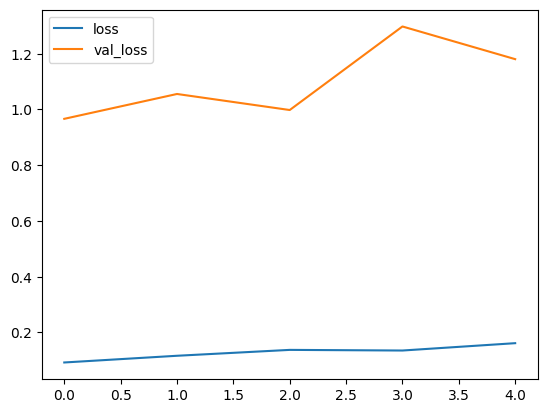

In [36]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [37]:
print(classification_report(val.get('target'), binary_predictions))
# layer connectivity visualization
#tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

              precision    recall  f1-score   support

           0       0.91      1.00      0.96     58511
           1       0.00      0.00      0.00      5448

    accuracy                           0.91     63959
   macro avg       0.46      0.50      0.48     63959
weighted avg       0.84      0.91      0.87     63959



c:\Users\Rawan Alamily\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rawan Alamily\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rawan Alamily\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [38]:
def df_to_dataset(df, batch_size=32, resample=False):
    df = df.copy()
    if resample:
        pos_df = df[df['target'] == 1]
        neg_df = df[df['target'] == 0]
        pos_labels = pos_df.pop('target')
        pos_features = pos_df
        neg_labels = neg_df.pop('target')
        neg_features = neg_df
        pos_ds = tf.data.Dataset.from_tensor_slices((dict(pos_features), pos_labels))
        neg_ds = tf.data.Dataset.from_tensor_slices((dict(neg_features), neg_labels))
        
        resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
        #resampled_ds = resampled_ds.apply(tf.data.experimental.assert_cardinality(54748))
        #resampled_ds = resampled_ds.shuffle(buffer_size=len(df))
        resampled_ds = resampled_ds.batch(batch_size).prefetch(2)
        return resampled_ds
    else:
        labels = df.pop('target')
        tf_dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels)).cache()
        # shuffled_tf_dataset = tf_dataset.shuffle(buffer_size=len(df)) # shuffling values 
        return tf_dataset.batch(batch_size).prefetch(2)# returning 32 samples per batch

In [39]:
# with large batch size
batch_size=256
# train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train, val = train_test_split(dataframe, test_size=0.2, random_state=RANDOM_SEED)
resampled_train_ds = df_to_dataset(df=train, batch_size=batch_size, resample=True)
val_ds = df_to_dataset(df=val, batch_size=batch_size, resample=False)
# test_ds = df_to_dataset(df=test, batch_size=batch_size)
steps_per_epoch = np.ceil(2.0*pos/batch_size)
##print(steps_per_epoch)

In [40]:
def get_normalization_layer(feature_name, dataset):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_ds)
    return normalizer
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_ds)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [41]:
# preprocess all features:
inputs = []
encoded_features =[]

# numerical
for header in ["bmi", "physicalHealth", "mentalHealth", 'sleepHours' ]:
    num_col = tf.keras.Input(shape=(1,), name=header)
    # keras inputs array
    inputs.append(num_col)

    norm_layer = get_normalization_layer(feature_name=header, dataset=resampled_train_ds)
    encoded_num_col = norm_layer(num_col)
    # encoded feature
    encoded_features.append(encoded_num_col)

# categorical
for header in ["smoking","alcoholDrinking","stroke","diffWalk",
                "sex", "ageGroup", "diabetic", "physicalActivity", 
                "overallHealth", "asthma", "kidneyDisease", "skinCancer"]:
    
    # declare header as a keras Input
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # keras inputs array
    inputs.append(cat_col)

    # get preprocessing layer 
    cat_layer = get_category_encoding_layer(feature_name=header,
                                            dataset=resampled_train_ds, 
                                            dtype='string', 
                                            max_tokens=None)
    encoded_cat_col = cat_layer(cat_col)
    # encoded feature
    encoded_features.append(encoded_cat_col)

In [42]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=128, activation="relu")(features)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [43]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(resampled_train_ds, 
                    validation_data=val_ds, 
                    epochs=20,
                    steps_per_epoch=steps_per_epoch,
                    use_multiprocessing=True, 
                    verbose=2)

predictions = model.predict(val_ds)

binary_predictions = tf.round(predictions).numpy().flatten()

Epoch 1/20
214/214 - 9s - loss: 0.4313 - accuracy: 0.7864 - val_loss: 0.7889 - val_accuracy: 0.9148 - 9s/epoch - 40ms/step
Epoch 2/20
214/214 - 7s - loss: 5.8388e-05 - accuracy: 1.0000 - val_loss: 0.8481 - val_accuracy: 0.9148 - 7s/epoch - 31ms/step
Epoch 3/20
214/214 - 6s - loss: 3.7523e-05 - accuracy: 1.0000 - val_loss: 0.8850 - val_accuracy: 0.9148 - 6s/epoch - 27ms/step
Epoch 4/20
214/214 - 6s - loss: 2.5591e-05 - accuracy: 1.0000 - val_loss: 0.9184 - val_accuracy: 0.9148 - 6s/epoch - 26ms/step
Epoch 5/20
214/214 - 5s - loss: 1.9948e-05 - accuracy: 1.0000 - val_loss: 0.9402 - val_accuracy: 0.9148 - 5s/epoch - 24ms/step
250/250 [==============================] - 3s 9ms/step


In [47]:
heart_csv_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/explainable-ai-heart/models/lifestyle-metrics-model/data/life-heart.csv'
dataframe = pd.read_csv(heart_csv_path)
print(dataframe.describe())
print(dataframe.shape)
dataframe['target'] = np.where(dataframe['heartDisease']=='Yes', 1, 0)
dataframe = dataframe.drop(columns=['heartDisease'])
dataframe = dataframe.sample(frac=1)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
neg, pos = np.bincount(dataframe['target'])

                 bmi  physicalHealth   mentalHealth     sleepHours
count  319795.000000    319795.00000  319795.000000  319795.000000
mean       28.325399         3.37171       3.898366       7.097075
std         6.356100         7.95085       7.955235       1.436007
min        12.020000         0.00000       0.000000       1.000000
25%        24.030000         0.00000       0.000000       6.000000
50%        27.340000         0.00000       0.000000       7.000000
75%        31.420000         2.00000       3.000000       8.000000
max        94.850000        30.00000      30.000000      24.000000
(319795, 17)


In [48]:
def df_to_dataset(df, batch_size=32, resample=False):
    df = df.copy()
    if resample:
        pos_df = df[df['target'] == 1]
        neg_df = df[df['target'] == 0]
        pos_labels = pos_df.pop('target')
        pos_features = pos_df
        neg_labels = neg_df.pop('target')
        neg_features = neg_df
        pos_ds = tf.data.Dataset.from_tensor_slices((dict(pos_features), pos_labels))
        neg_ds = tf.data.Dataset.from_tensor_slices((dict(neg_features), neg_labels))
        
        resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
        #resampled_ds = resampled_ds.apply(tf.data.experimental.assert_cardinality(54748))
        #resampled_ds = resampled_ds.shuffle(buffer_size=len(df))
        resampled_ds = resampled_ds.batch(batch_size).prefetch(2)
        return resampled_ds
    else:
        labels = df.pop('target')
        tf_dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels)).cache()
        # shuffled_tf_dataset = tf_dataset.shuffle(buffer_size=len(df)) # shuffling values 
        return tf_dataset.batch(batch_size).prefetch(2)# returning 32 samples per batch

In [49]:
# with large batch size
batch_size=2048
# train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train, val = train_test_split(dataframe, test_size=0.2, random_state=RANDOM_SEED)
resampled_train_ds = df_to_dataset(df=train, batch_size=batch_size, resample=True)
val_ds = df_to_dataset(df=val, batch_size=batch_size, resample=False)
# test_ds = df_to_dataset(df=test, batch_size=batch_size)
steps_per_epoch = np.ceil(2.0*pos/batch_size)
print(steps_per_epoch)

27.0


In [50]:
def get_normalization_layer(feature_name, dataset):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_ds)
    return normalizer
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_ds)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [51]:
# preprocess all features:
inputs = []
encoded_features =[]

# numerical
for header in ["bmi", "physicalHealth", "mentalHealth", 'sleepHours' ]:
    num_col = tf.keras.Input(shape=(1,), name=header)
    # keras inputs array
    inputs.append(num_col)

    norm_layer = get_normalization_layer(feature_name=header, dataset=resampled_train_ds)
    encoded_num_col = norm_layer(num_col)
    # encoded feature
    encoded_features.append(encoded_num_col)

# categorical
for header in ["smoking","alcoholDrinking","stroke","diffWalk",
                "sex", "ageGroup", "diabetic", "physicalActivity", 
                "overallHealth", "asthma", "kidneyDisease", "skinCancer"]:
    
    # declare header as a keras Input
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # keras inputs array
    inputs.append(cat_col)

    # get preprocessing layer 
    cat_layer = get_category_encoding_layer(feature_name=header,
                                            dataset=resampled_train_ds, 
                                            dtype='string', 
                                            max_tokens=None)
    encoded_cat_col = cat_layer(cat_col)
    # encoded feature
    encoded_features.append(encoded_cat_col)

In [52]:
# with large batch size
batch_size=64
# train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train, val = train_test_split(dataframe, test_size=0.2, random_state=RANDOM_SEED)
resampled_train_ds = df_to_dataset(df=train, batch_size=batch_size, resample=True)
val_ds = df_to_dataset(df=val, batch_size=batch_size, resample=False)
# test_ds = df_to_dataset(df=test, batch_size=batch_size)
steps_per_epoch = np.ceil(2.0*pos/batch_size)
print(steps_per_epoch)

856.0


In [53]:
# with large batch size
batch_size=2048
# train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train, val = train_test_split(dataframe, test_size=0.2, random_state=RANDOM_SEED)
resampled_train_ds = df_to_dataset(df=train, batch_size=batch_size, resample=True)
val_ds = df_to_dataset(df=val, batch_size=batch_size, resample=False)
# test_ds = df_to_dataset(df=test, batch_size=batch_size)
steps_per_epoch = np.ceil(2.0*pos/batch_size)
print(steps_per_epoch)

27.0


In [54]:
# preprocess all features:
inputs = []
encoded_features =[]

# numerical
for header in ["bmi", "physicalHealth", "mentalHealth", 'sleepHours' ]:
    num_col = tf.keras.Input(shape=(1,), name=header)
    # keras inputs array
    inputs.append(num_col)

    norm_layer = get_normalization_layer(feature_name=header, dataset=resampled_train_ds)
    encoded_num_col = norm_layer(num_col)
    # encoded feature
    encoded_features.append(encoded_num_col)

# categorical
for header in ["smoking","alcoholDrinking","stroke","diffWalk",
                "sex", "ageGroup", "diabetic", "physicalActivity", 
                "overallHealth", "asthma", "kidneyDisease", "skinCancer"]:
    
    # declare header as a keras Input
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # keras inputs array
    inputs.append(cat_col)

    # get preprocessing layer 
    cat_layer = get_category_encoding_layer(feature_name=header,
                                            dataset=resampled_train_ds, 
                                            dtype='string', 
                                            max_tokens=None)
    encoded_cat_col = cat_layer(cat_col)
    # encoded feature
    encoded_features.append(encoded_cat_col)

In [55]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=128, activation="relu")(features)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [56]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(resampled_train_ds, 
                    validation_data=val_ds, 
                    epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    use_multiprocessing=True, 
                    verbose=2)

predictions = model.predict(val_ds)

binary_predictions = tf.round(predictions).numpy().flatten()

Epoch 1/5
27/27 - 6s - loss: 0.5594 - accuracy: 0.7090 - val_loss: 0.2605 - val_accuracy: 0.9039 - 6s/epoch - 214ms/step
Epoch 2/5
27/27 - 3s - loss: 0.0264 - accuracy: 0.9971 - val_loss: 0.5628 - val_accuracy: 0.9148 - 3s/epoch - 102ms/step
Epoch 3/5
27/27 - 3s - loss: 5.8386e-04 - accuracy: 1.0000 - val_loss: 0.6495 - val_accuracy: 0.9148 - 3s/epoch - 99ms/step
Epoch 4/5
27/27 - 3s - loss: 3.3449e-04 - accuracy: 1.0000 - val_loss: 0.6753 - val_accuracy: 0.9148 - 3s/epoch - 119ms/step
Epoch 5/5
27/27 - 2s - loss: 2.7680e-04 - accuracy: 1.0000 - val_loss: 0.6882 - val_accuracy: 0.9148 - 2s/epoch - 92ms/step
32/32 [==============================] - 2s 23ms/step


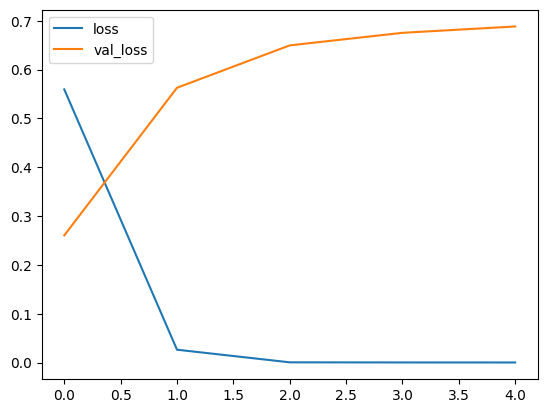

In [57]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [59]:
heart_csv_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/explainable-ai-heart/models/lifestyle-metrics-model/data/life-heart.csv'
dataframe = pd.read_csv(heart_csv_path)
print(dataframe.describe())
print(dataframe.shape)
dataframe['target'] = np.where(dataframe['heartDisease']=='Yes', 1, 0)
dataframe = dataframe.drop(columns=['heartDisease'])
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
neg, pos = np.bincount(dataframe['target'])

                 bmi  physicalHealth   mentalHealth     sleepHours
count  319795.000000    319795.00000  319795.000000  319795.000000
mean       28.325399         3.37171       3.898366       7.097075
std         6.356100         7.95085       7.955235       1.436007
min        12.020000         0.00000       0.000000       1.000000
25%        24.030000         0.00000       0.000000       6.000000
50%        27.340000         0.00000       0.000000       7.000000
75%        31.420000         2.00000       3.000000       8.000000
max        94.850000        30.00000      30.000000      24.000000
(319795, 17)


In [60]:
def df_to_dataset(df, batch_size=32, resample=False):
    df = df.copy()
    if resample:
        pos_df = df[df['target'] == 1]
        neg_df = df[df['target'] == 0]
        pos_labels = pos_df.pop('target')
        pos_features = pos_df
        neg_labels = neg_df.pop('target')
        neg_features = neg_df
        pos_ds = tf.data.Dataset.from_tensor_slices((dict(pos_features), pos_labels))
        neg_ds = tf.data.Dataset.from_tensor_slices((dict(neg_features), neg_labels))
        
        resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
        #resampled_ds = resampled_ds.apply(tf.data.experimental.assert_cardinality(54748))
        resampled_ds = resampled_ds.shuffle(buffer_size=len(df))
        resampled_ds = resampled_ds.batch(batch_size).prefetch(2)
        return resampled_ds
    else:
        labels = df.pop('target')
        tf_dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels)).cache()
        # shuffled_tf_dataset = tf_dataset.shuffle(buffer_size=len(df)) # shuffling values 
        return tf_dataset.batch(batch_size).prefetch(2)# returning 32 samples per batch

In [61]:
def df_to_dataset(df, batch_size=32, resample=False):
    df = df.copy()
    if resample:
        pos_df = df[df['target'] == 1]
        neg_df = df[df['target'] == 0]
        pos_labels = pos_df.pop('target')
        pos_features = pos_df
        neg_labels = neg_df.pop('target')
        neg_features = neg_df
        pos_ds = tf.data.Dataset.from_tensor_slices((dict(pos_features), pos_labels))
        neg_ds = tf.data.Dataset.from_tensor_slices((dict(neg_features), neg_labels))
        
        resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
        #resampled_ds = resampled_ds.apply(tf.data.experimental.assert_cardinality(54748))
        resampled_ds = resampled_ds.shuffle(buffer_size=len(df))
        resampled_ds = resampled_ds.batch(batch_size).prefetch(2)
        return resampled_ds
    else:
        labels = df.pop('target')
        tf_dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels)).cache()
        shuffled_tf_dataset = tf_dataset.shuffle(buffer_size=len(df)) # shuffling values 
        return tf_dataset.batch(batch_size).prefetch(2)# returning 32 samples per batch

In [62]:
# with large batch size
batch_size=64
# train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
dataframe = dataframe.sample(frac=1)
train, val = train_test_split(dataframe, test_size=0.3, random_state=RANDOM_SEED)
resampled_train_ds = df_to_dataset(df=train, batch_size=batch_size, resample=True)
val_ds = df_to_dataset(df=val, batch_size=batch_size, resample=False)
# test_ds = df_to_dataset(df=test, batch_size=batch_size)
steps_per_epoch = np.ceil(2.0*pos/batch_size)
print(steps_per_epoch)

856.0


In [64]:
def get_normalization_layer(feature_name, dataset):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_ds)
    return normalizer
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_ds)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [65]:
# preprocess all features:
inputs = []
encoded_features =[]

# numerical
for header in ["bmi", "physicalHealth", "mentalHealth", 'sleepHours' ]:
    num_col = tf.keras.Input(shape=(1,), name=header)
    # keras inputs array
    inputs.append(num_col)

    norm_layer = get_normalization_layer(feature_name=header, dataset=resampled_train_ds)
    encoded_num_col = norm_layer(num_col)
    # encoded feature
    encoded_features.append(encoded_num_col)

# categorical
for header in ["smoking","alcoholDrinking","stroke","diffWalk",
                "sex", "ageGroup", "diabetic", "physicalActivity", 
                "overallHealth", "asthma", "kidneyDisease", "skinCancer"]:
    
    # declare header as a keras Input
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # keras inputs array
    inputs.append(cat_col)

    # get preprocessing layer 
    cat_layer = get_category_encoding_layer(feature_name=header,
                                            dataset=resampled_train_ds, 
                                            dtype='string', 
                                            max_tokens=None)
    encoded_cat_col = cat_layer(cat_col)
    # encoded feature
    encoded_features.append(encoded_cat_col)

In [66]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=128, activation="relu")(features)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [68]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(resampled_train_ds, 
                    validation_data=val_ds, 
                    epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    use_multiprocessing=True, 
                    verbose=1)

predictions = model.predict(val_ds)

binary_predictions = tf.round(predictions).numpy().flatten()

Epoch 1/5
856/856 [==============================] - 34s 27ms/step - loss: 0.2323 - accuracy: 0.9149 - val_loss: 0.2344 - val_accuracy: 0.9150
Epoch 2/5
856/856 [==============================] - 18s 21ms/step - loss: 0.2261 - accuracy: 0.9170 - val_loss: 0.2305 - val_accuracy: 0.9155
Epoch 3/5
856/856 [==============================] - 19s 22ms/step - loss: 0.2270 - accuracy: 0.9165 - val_loss: 0.2292 - val_accuracy: 0.9157
Epoch 4/5
856/856 [==============================] - 19s 22ms/step - loss: 0.2270 - accuracy: 0.9154 - val_loss: 0.2287 - val_accuracy: 0.9153
Epoch 5/5
1500/1500 [==============================] - 10s 6ms/step


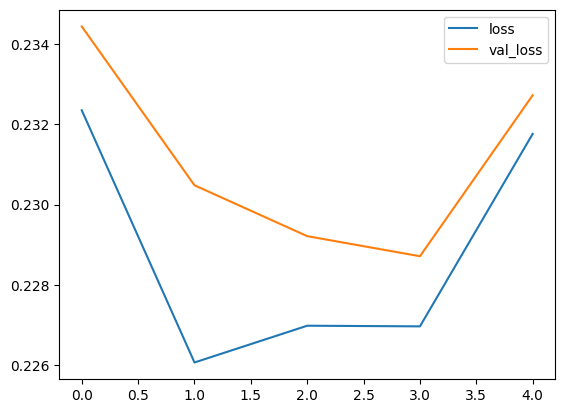

In [69]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [70]:
print(classification_report(val.get('target'), binary_predictions))
# layer connectivity visualization
#tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     87681
           1       0.61      0.05      0.10      8258

    accuracy                           0.92     95939
   macro avg       0.76      0.53      0.53     95939
weighted avg       0.89      0.92      0.88     95939



In [71]:
def df_to_dataset(df, batch_size=32, resample=False):
    df = df.copy()
    if resample:
        pos_df = df[df['target'] == 1]
        neg_df = df[df['target'] == 0]
        pos_labels = pos_df.pop('target')
        pos_features = pos_df
        neg_labels = neg_df.pop('target')
        neg_features = neg_df
        pos_ds = tf.data.Dataset.from_tensor_slices((dict(pos_features), pos_labels))
        neg_ds = tf.data.Dataset.from_tensor_slices((dict(neg_features), neg_labels))
        
        resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
        #resampled_ds = resampled_ds.apply(tf.data.experimental.assert_cardinality(54748))
        resampled_ds = resampled_ds.shuffle(buffer_size=len(df))
        resampled_ds = resampled_ds.batch(batch_size).prefetch(2).repeat()
        return resampled_ds
    else:
        labels = df.pop('target')
        tf_dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels)).cache()
        shuffled_tf_dataset = tf_dataset.shuffle(buffer_size=len(df)) # shuffling values 
        return tf_dataset.batch(batch_size).prefetch(2)# returning 32 samples per batch

In [72]:
# with large batch size
batch_size=64
# train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
dataframe = dataframe.sample(frac=1)
train, val = train_test_split(dataframe, test_size=0.3, random_state=RANDOM_SEED)
resampled_train_ds = df_to_dataset(df=train, batch_size=batch_size, resample=True)
val_ds = df_to_dataset(df=val, batch_size=batch_size, resample=False)
# test_ds = df_to_dataset(df=test, batch_size=batch_size)
steps_per_epoch = np.ceil(2.0*pos/batch_size)
print(steps_per_epoch)

856.0


In [73]:
def get_normalization_layer(feature_name, dataset):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_ds)
    return normalizer
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_ds)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [74]:
# preprocess all features:
inputs = []
encoded_features =[]

# numerical
for header in ["bmi", "physicalHealth", "mentalHealth", 'sleepHours' ]:
    num_col = tf.keras.Input(shape=(1,), name=header)
    # keras inputs array
    inputs.append(num_col)

    norm_layer = get_normalization_layer(feature_name=header, dataset=resampled_train_ds)
    encoded_num_col = norm_layer(num_col)
    # encoded feature
    encoded_features.append(encoded_num_col)

# categorical
for header in ["smoking","alcoholDrinking","stroke","diffWalk",
                "sex", "ageGroup", "diabetic", "physicalActivity", 
                "overallHealth", "asthma", "kidneyDisease", "skinCancer"]:
    
    # declare header as a keras Input
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # keras inputs array
    inputs.append(cat_col)

    # get preprocessing layer 
    cat_layer = get_category_encoding_layer(feature_name=header,
                                            dataset=resampled_train_ds, 
                                            dtype='string', 
                                            max_tokens=None)
    encoded_cat_col = cat_layer(cat_col)
    # encoded feature
    encoded_features.append(encoded_cat_col)

ValueError: When providing an infinite dataset, you must specify the number of steps to run (if you did not intend to create an infinite dataset, make sure to not call `repeat()` on the dataset).

In [75]:
def get_normalization_layer(feature_name, dataset):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_ds, batch_size=batch_size, steps=steps_per_epoch)
    return normalizer
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_ds, batch_size=batch_size, steps=steps_per_epoch)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [76]:
# preprocess all features:
inputs = []
encoded_features =[]

# numerical
for header in ["bmi", "physicalHealth", "mentalHealth", 'sleepHours' ]:
    num_col = tf.keras.Input(shape=(1,), name=header)
    # keras inputs array
    inputs.append(num_col)

    norm_layer = get_normalization_layer(feature_name=header, dataset=resampled_train_ds)
    encoded_num_col = norm_layer(num_col)
    # encoded feature
    encoded_features.append(encoded_num_col)

# categorical
for header in ["smoking","alcoholDrinking","stroke","diffWalk",
                "sex", "ageGroup", "diabetic", "physicalActivity", 
                "overallHealth", "asthma", "kidneyDisease", "skinCancer"]:
    
    # declare header as a keras Input
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # keras inputs array
    inputs.append(cat_col)

    # get preprocessing layer 
    cat_layer = get_category_encoding_layer(feature_name=header,
                                            dataset=resampled_train_ds, 
                                            dtype='string', 
                                            max_tokens=None)
    encoded_cat_col = cat_layer(cat_col)
    # encoded feature
    encoded_features.append(encoded_cat_col)

In [77]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=128, activation="relu")(features)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [78]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(resampled_train_ds, 
                    validation_data=val_ds, 
                    epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    use_multiprocessing=True, 
                    verbose=1)

predictions = model.predict(val_ds)

binary_predictions = tf.round(predictions).numpy().flatten()

Epoch 1/5
856/856 [==============================] - 18s 16ms/step - loss: 0.2387 - accuracy: 0.9142 - val_loss: 0.2288 - val_accuracy: 0.9142
Epoch 2/5
856/856 [==============================] - 11s 13ms/step - loss: 0.2278 - accuracy: 0.9162 - val_loss: 0.2276 - val_accuracy: 0.9153
Epoch 3/5
856/856 [==============================] - 13s 15ms/step - loss: 0.2325 - accuracy: 0.9146 - val_loss: 0.2286 - val_accuracy: 0.9153
Epoch 4/5
856/856 [==============================] - 17s 20ms/step - loss: 0.2296 - accuracy: 0.9158 - val_loss: 0.2313 - val_accuracy: 0.9156
Epoch 5/5
1500/1500 [==============================] - 9s 5ms/step


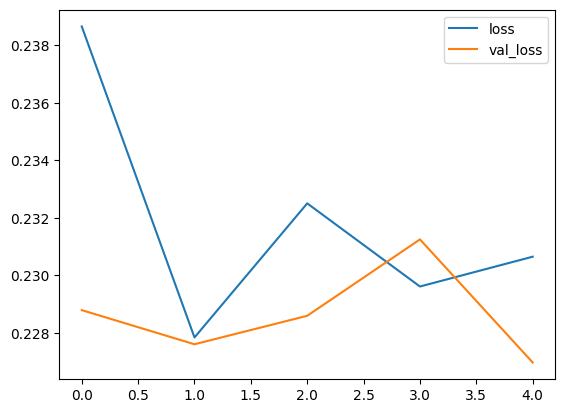

In [79]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [80]:
print(classification_report(val.get('target'), binary_predictions))
# layer connectivity visualization
#tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     87722
           1       0.58      0.05      0.09      8217

    accuracy                           0.92     95939
   macro avg       0.75      0.52      0.52     95939
weighted avg       0.89      0.92      0.88     95939



In [81]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(resampled_train_ds, 
                    validation_data=val_ds, 
                    epochs=20,
                    steps_per_epoch=steps_per_epoch,
                    use_multiprocessing=True, 
                    verbose=1)

predictions = model.predict(val_ds)

binary_predictions = tf.round(predictions).numpy().flatten()

Epoch 1/20
856/856 [==============================] - 19s 18ms/step - loss: 0.2317 - accuracy: 0.9149 - val_loss: 0.2274 - val_accuracy: 0.9158
Epoch 2/20
856/856 [==============================] - 16s 19ms/step - loss: 0.2269 - accuracy: 0.9165 - val_loss: 0.2277 - val_accuracy: 0.9156
Epoch 3/20
856/856 [==============================] - 16s 19ms/step - loss: 0.2272 - accuracy: 0.9165 - val_loss: 0.2264 - val_accuracy: 0.9153
Epoch 4/20
856/856 [==============================] - 15s 18ms/step - loss: 0.2252 - accuracy: 0.9164 - val_loss: 0.2269 - val_accuracy: 0.9151
Epoch 5/20
856/856 [==============================] - 19s 22ms/step - loss: 0.2227 - accuracy: 0.9177 - val_loss: 0.2260 - val_accuracy: 0.9155
Epoch 6/20
856/856 [==============================] - 17s 20ms/step - loss: 0.2295 - accuracy: 0.9156 - val_loss: 0.2272 - val_accuracy: 0.9144
Epoch 7/20
856/856 [==============================] - 17s 20ms/step - loss: 0.2260 - accuracy: 0.9160 - val_loss: 0.2268 - val_accuracy:

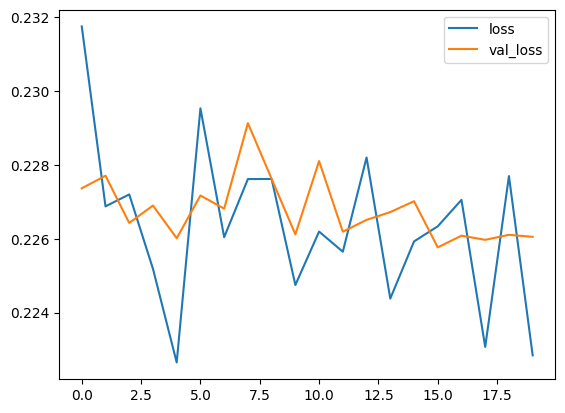

In [82]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [83]:
print(classification_report(val.get('target'), binary_predictions))
# layer connectivity visualization
#tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     87722
           1       0.55      0.08      0.13      8217

    accuracy                           0.92     95939
   macro avg       0.73      0.53      0.54     95939
weighted avg       0.89      0.92      0.89     95939

